### Neural Computation Exercise 6: Advanced Optimization Algorithms

In this exercise, we'll develop implementations of advanced optimization algorithms. As in Exercise 2, we will use the Boston Housing dataset and run some advanced optimization algorithms to solved the linear regression problems.

In this exercise, you will learn the following
* implement the `momentum` method
* implement the `Nesterov momentum` method
* implement the `adaptive (stochastic) gradient descent` method

In [1]:
import matplotlib
import numpy as np
import random
import warnings
import matplotlib.pyplot as plt 
from sklearn import preprocessing   # for normalization

## Boston Housing Data

The Boston Housing data is one of the  datasets available in sklearn.
We can import the dataset and preprocess it as follows. Note we add a feature of $1$ to `x_input` to get a n x (d+1) matrix `x_in`

In [2]:
from sklearn.datasets import load_boston
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    boston_data = load_boston()
data = boston_data['data']
x_input = data  # a data matrix
y_target = boston_data['target'] # a vector for all outputs
# add a feature 1 to the dataset, then we do not need to consider the bias and weight separately
x_in = np.concatenate([np.ones([np.shape(x_input)[0], 1]), x_input], axis=1)
# we normalize the data so that each has regularity
x_in = preprocessing.normalize(x_in)

## Linear Model

A linear regression model in one variable has the following form 
$$
f(x)=\mathbf{w}^\top \mathbf{x}.
$$
The following function computes the output of the linear model on a data matrix of size n x (d+1).

In [3]:
def linearmat_2(w, X):
    '''
    a vectorization of linearmat_1 in lab 2.
    Input: w is a weight parameter (including the bias), and X is a data matrix (n x (d+1)) (including the feature)
    Output: a vector containing the predictions of linear models
    '''
    return np.dot(X, w)

## Cost Function

We defined the following `mean square error` function for a linear regression problem using the square loss:
$$
C(\mathbf{y}, \mathbf{t}) = \frac{1}{2n}(\mathbf{y}-\mathbf{t})^\top (\mathbf{y}-\mathbf{t}).
$$
The python implementation is as follows

In [4]:
def cost(w, X, y):
    '''
    Evaluate the cost function in a vectorized manner for 
    inputs `X` and outputs `y`, at weights `w`.
    '''
    residual = y - linearmat_2(w, X)  # get the residual
    err = np.dot(residual, residual) / (2 * len(y)) # compute the error
    
    return err

## Gradient Computation

Our methods require to use the gradient of the `cost` function. As discussed in the previous lecture, the gradient can be computed by
$$\nabla C(\mathbf{w}) =\frac{1}{n}X^\top\big(X\mathbf{w}-\mathbf{y}\big)$$
In the following, we present the python implementation on the gradient computation

In [5]:
# Vectorized gradient function
def gradfn(weights, X, y):
    '''
    Given `weights` - a current "Guess" of what our weights should be
          `X` - matrix of shape (N,d+1) of input features including the feature $1$
          `y` - target y values
    Return gradient of each weight evaluated at the current value
    '''

    y_pred = np.dot(X, weights)
    error = y_pred - y
    return np.dot(X.T, error) / len(y)

## Gradient Descent

Gradient Descent iteratively updates the model by moving along the negative direction
$$\mathbf{w}^{(t+1)} \leftarrow \mathbf{w}^{(t)} - \eta\nabla C(\mathbf{w}^{(t)}),$$ 
where $\eta$ is a learning rate and $\nabla C(w^{(t)})$ is the gradient evaluated at current parameter value $\mathbf{w}^{(t)}$. In the following, we give the python implementation of the gradient descent on the linear regression problem. Here, we use `idx_res` to store the indices of iterations where we have computed the cost, and use `err_res` to store the cost of models at these iterations. These will be used to plot how the `cost` will behave `versus iteration` number.

In [6]:
def solve_via_gradient_descent(X, y, print_every=100,
                               niter=2000, eta=1):
    '''
    Solves for linear regression weights with gradient descent.
    Given `X` - matrix of shape (N,D) of input features
          `y` - target y values
          `print_every` - we report performance every 'print_every' iterations
          `niter` - the number of iterates allowed
          `eta` - learning rate
    
    Return 
        `w` - weights after `niter` iterations
        `idx_res` - the indices of iterations where we compute the cost
        `err_res` - the cost at iterations indicated by idx_res
    '''
    N, D = np.shape(X)
    # initialize all the weights to zeros
    w = np.zeros([D])
    idx_res = []
    err_res = []
    for k in range(niter):
        # compute the gradient
        dw = gradfn(w, X, y)
        # gradient descent
        w = w - eta * dw
        # we report the progress every print_every iterations
        # note the operator % calculates the remainder of dividing two values
        if k % print_every == print_every - 1:
            t_cost = cost(w, X, y)
            print('error after %d iteration: %s' % (k, t_cost))
            idx_res.append(k)
            err_res.append(t_cost)
    return w, idx_res, err_res

Now we apply **gradient descent** to solve the **Boston House Price** prediction problem, and get the weight `w_gd`, the indices `idx_gd` and the errors 'err_gd' on these indices 

In [7]:
w_gd, idx_gd, err_gd = solve_via_gradient_descent( X=x_in, y=y_target)

error after 99 iteration: 31.791693326233137
error after 199 iteration: 31.023607992661905
error after 299 iteration: 30.490383155279734
error after 399 iteration: 30.089558295291926
error after 499 iteration: 29.7657684545607
error after 599 iteration: 29.4886933766529
error after 699 iteration: 29.241419443720766
error after 799 iteration: 29.014275853482033
error after 899 iteration: 28.801555744273422
error after 999 iteration: 28.599760789662742
error after 1099 iteration: 28.406652720498357
error after 1199 iteration: 28.220734140804872
error after 1299 iteration: 28.04095920855526
error after 1399 iteration: 27.86656854307502
error after 1499 iteration: 27.696992152320217
error after 1599 iteration: 27.531790279455215
error after 1699 iteration: 27.37061589773194
error after 1799 iteration: 27.213189941761843
error after 1899 iteration: 27.059284304933385
error after 1999 iteration: 26.908709763895015


## Momentum

Momentum introduces a variable `velocity` to store the historical information of the gradients. At each iteration, it updates `velocity` as a factor of the current `velocity` minus the `learning rate` times the `current gradient`
$$\mathbf{v}^{(t+1)} = \alpha\mathbf{v}^{(t)}-\eta\nabla C(\mathbf{w}^{(t)}),$$ 
where $\eta$ is a learning rate, $\alpha\in(0,1)$ is a parameter and $\nabla C(w^{(t)}$ is the gradient evaluated at current parameter value $\mathbf{w}^{(t)}$.
Then, we update the next iterate as 
$$\mathbf{w}^{(t+1)}=\mathbf{w}^{(t)}+\mathbf{v}^{(t+1)}.$$
In the following, we request you to finish the following implementation of the `momentum` on the linear regression problem.

In [10]:
def solve_via_momentum(X, y, print_every=100,
                               niter=2000, eta=1, alpha=0.8):
    '''
    Solves for linear regression weights with momentum.
    Given `X` - matrix of shape (N,D) of input features
          `y` - target y values
          `print_every` - we report performance every 'print_every' iterations
          `niter` - the number of iterates allowed
          `eta` - learning rate
          `alpha` - determines the influence of past gradients on the current update

    Return 
        `w` - weights after `niter` iterations
        `idx_res` - the indices of iterations where we compute the cost
        `err_res` - the cost at iterations
    '''
    N, D = np.shape(X)
    # initialize all the weights to zeros
    w = np.zeros([D])
    v = np.zeros([D])
    idx_res = []
    err_res = []
    for k in range(niter):
        # TODO: Insert your code to update w by momentum
        v = alpha * v - eta * gradfn(w, X, y)
        w += v 
    
    
    
        if k % print_every == print_every - 1:
            t_cost = cost(w, X, y)
            print('error after %d iteration: %s' % (k, t_cost))
            idx_res.append(k)
            err_res.append(t_cost)
    return w, idx_res, err_res

Now we apply **momentum** to solve the **Boston House Price** prediction problem.

In [11]:
w_momentum, idx_momentum, err_momentum = solve_via_momentum( X=x_in, y=y_target)

error after 99 iteration: 29.80056562307084
error after 199 iteration: 28.629994288393853
error after 299 iteration: 27.723453738429058
error after 399 iteration: 26.931701969094917
error after 499 iteration: 26.220751546713966
error after 599 iteration: 25.5765919232023
error after 699 iteration: 24.991046371326643
error after 799 iteration: 24.458021242865858
error after 899 iteration: 23.97238648687385
error after 999 iteration: 23.529615039194642
error after 1099 iteration: 23.125646524151133
error after 1199 iteration: 22.75681939168434
error after 1299 iteration: 22.419825742699732
error after 1399 iteration: 22.111675234519236
error after 1499 iteration: 21.829663857823594
error after 1599 iteration: 21.571346141332416
error after 1699 iteration: 21.334510167960573
error after 1799 iteration: 21.11715504655761
error after 1899 iteration: 20.917470576437516
error after 1999 iteration: 20.73381888454735


### Comparison between Gradient Descent and Gradient Descent with Momentum

We can now compare the behavie of Gradient Descent and Gradient Descent with Momentum. In particular, we will show how the `cost` of models found by the algorithm at different iterations would behave with respect to the iteration number.

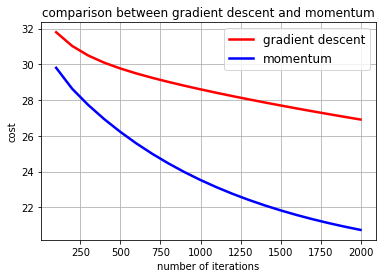

In [12]:
# we plot the cost w.r.t. the iteration number
plt.plot(idx_gd, err_gd, color="red", linewidth=2.5, linestyle="-", label="gradient descent") #  gradient descent
plt.plot(idx_momentum, err_momentum, color="blue", linewidth=2.5, linestyle="-", label="momentum") # momentum
plt.legend(loc='upper right', prop={'size': 12})
plt.title('comparison between gradient descent and momentum')
plt.xlabel("number of iterations")
plt.ylabel("cost")
plt.grid()
plt.show()

As we expected, **gradient descent with momentum** is much faster than the **gradient descent**. This shows the benefit of using velocity to store historical gradient information for accelerating the algorithm.

## Nesterov Momentum

Anoter algorithm which can acclerate the training speed of gradient descent is the **Nesterov Momentum**. Analogous to **Momentum**, Nesterov Momentum also introduces a variable `velocity` to store the historical information of the gradients. The difference is that it first uses the current velocity to build a `looking ahead` point. Then the gradient computation is performed at the  `looking ahead` point. The `looking ahead` point may contain more information than the current point. Therefore, the gradient at `looking ahead` point may be more precise than the `current gradient`.
The update equation is as follows
$$\mathbf{w}^{\text{(ahead)}}=\mathbf{w}^{(t)}+\alpha\mathbf{v}^{(t)}$$
$$\mathbf{v}^{(t+1)} = \alpha\mathbf{v}^{(t)}-\eta\nabla C(\mathbf{w}^{(\text{ahead})}),$$ 
where $\eta$ is a learning rate and $\alpha\in(0,1)$ is a parameter.
Then, we update the next iterate as 
$$\mathbf{w}^{(t+1)}=\mathbf{w}^{(t)}+\mathbf{v}^{(t+1)}.$$
In the following, we request you to finish the following implementation of the `Nesterov Momentum` on the linear regression problem.

In [13]:
def solve_via_nag(X, y, print_every=100,
                               niter=2000, eta=0.5, alpha=0.8):
    '''
    Solves for linear regression weights with nesterov momentum.
    Given `X` - matrix of shape (N,D) of input features
          `y` - target y values
          `print_every` - we report performance every 'print_every' iterations
          `niter` - the number of iterates allowed
          `eta` - learning rate
          `alpha` - determines the influence of past gradients on the current update

    Return 
        `w` - weights after `niter` iterations
        `idx_res` - the indices of iterations where we compute the cost
        `err_res` - the cost at iterations
    '''
    N, D = np.shape(X)
    # initialize all the weights to zeros
    w = np.zeros([D])
    v = np.zeros([D])
    idx_res = []
    err_res = []
    for k in range(niter):
        # TODO: Insert your code to update w by nesterov momentum
        w_ahead = w + alpha * v
        v = alpha * v - eta * gradfn(w_ahead, X, y)
        w += v  
        
        
        
        if k % print_every == print_every - 1:
            t_cost = cost(w, X, y)
            print('error after %d iteration: %s' % (k, t_cost))
            idx_res.append(k)
            err_res.append(t_cost)
    return w, idx_res, err_res

Now we apply nesterov momentum to solve the Boston House Price prediction problem.

In [14]:
w_nag, idx_nag, err_nag = solve_via_nag( X=x_in, y=y_target)

error after 99 iteration: 30.771089795282066
error after 199 iteration: 29.785615718682827
error after 299 iteration: 29.143052960311884
error after 399 iteration: 28.61576462472077
error after 499 iteration: 28.145031255247847
error after 599 iteration: 27.710904010712206
error after 699 iteration: 27.30445729074942
error after 799 iteration: 26.92087123922468
error after 899 iteration: 26.557219300063483
error after 999 iteration: 26.211557121716073
error after 1099 iteration: 25.882480958675554
error after 1199 iteration: 25.56889656165967
error after 1299 iteration: 25.269894270324066
error after 1399 iteration: 24.98468044406956
error after 1499 iteration: 24.71253935901087
error after 1599 iteration: 24.452811706720944
error after 1699 iteration: 24.20488217625198
error after 1799 iteration: 23.968172024438886
error after 1899 iteration: 23.74213440013609
error after 1999 iteration: 23.526251201949723


### Comparison between Gradient Descent and Nesterov Momentum

We can now compare the behavie of Gradient Descent and Nesterov Momentum. In particular, we will show how the `cost` of models found by the algorithm at different iterations would behave with respect to the iteration number.

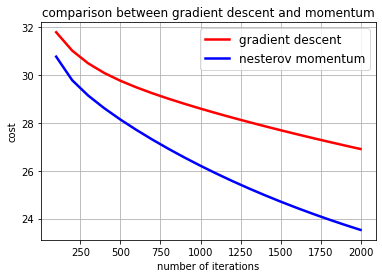

In [16]:
plt.plot(idx_gd, err_gd, color="red", linewidth=2.5, linestyle="-", label="gradient descent")
plt.plot(idx_nag, err_nag, color="blue", linewidth=2.5, linestyle="-", label="nesterov momentum")
plt.legend(loc='upper right', prop={'size': 12})
plt.title('comparison between gradient descent and momentum')
plt.xlabel("number of iterations")
plt.ylabel("cost")
plt.grid()
plt.show()

As we expected, **nesterov momentum** is much faster than the **gradient descent**. This  again shows the benefit of using velocity to store historical gradient information for accelerating the algorithm.

## Adaptive Gradient Descent

Stochastic gradient descent uses the same learning rates for all the features. This can be problematic if there are some sparse and predictive features. The underlying reason is that there are few examples with non-zero values for the sparse features, and it is often the case that SGD will choose an example with a zero for the sparse feature. Then it would not update the corresponding coordinate in this case. This motivates the need to slow down the update of some coordinates if there is already a frequent update on that coordinate, and accelerate the update if there are few updates on that coordinate.

The key idea of `Adagrad` is to introduce a vector $\mathbf{r}$ to store the accumulated gradient norm square. We initialize $\mathbf{r}^{(0)}=0$ and update
$$ 
\mathbf{r}^{(t+1)}=\mathbf{r}^{(t)}+\hat{\mathbf{g}}^{(t)}\odot\hat{\mathbf{g}}^{(t)},
$$
where $\hat{\mathbf{g}}^{(t)}$ can be a stochastic gradient built based on a selected example or a minibatch of examples. Note $\mathbf{r}^{(t+1)}$ records the accumulated magnitude square of gradients in each coordinate up to the $t$-th iteration. In this way, the entries of $\mathbf{r}^{(t+1)}$ would be different. If ${r}_j^{(t+1)}$ is large, then this means that there are a lot of updates on the $j$-th coordinate. If ${r}_j^{(t+1)}$ is small, then this means that there are few updates on the $j$-th coordinate. The idea is to slow down the update on a coordinate if there are already many updates on that coordinate in the history, and speed up the update on a coordinate if there are few updates in the history. This can be achieved by dividing the parameter $\eta$ with $\sqrt{\mathbf{r}^{(t+1)}}$. That is
$$
\mathbf{w}^{(t+1)}\gets\mathbf{w}^{(t)}-\frac{\eta}{\delta+\sqrt{\mathbf{r}^{(t+1)}}}\odot \hat{\mathbf{g}}^{(t)} 
$$
In this way, we can have different learning rates on different coordinates. In the following, we request you to finish the following implementation of the `AdaGrad` on the linear regression problem. 

In [20]:
def solve_via_adagrad(X, y, print_every=100,
                               niter=5000, eta=1, batch_size=50):
    '''
    Solves for linear regression weights with nesterov momentum.
    Given `X` - matrix of shape (N,D) of input features
          `y` - target y values
          `print_every` - we report performance every 'print_every' iterations
          `niter` - the number of iterates allowed
          `eta` - learning rate
          `batch_size` - the size of minibatch
    Return 
        `w` - weights after `niter` iterations
        `idx_res` - the indices of iterations where we compute the cost
        `err_res` - the cost at iterations
    '''
    N, D = np.shape(X)
    # initialize all the weights to zeros
    w = np.zeros([D])
    idx_res = []
    err_res = []
    tset = list(range(N))
    gradients_sum = np.zeros([D])
    delta = 1e-8
    for k in range(niter):
        # TODO: Insert your code to update w by Adagrad
        idx = random.sample(tset, batch_size)
        #sample batch of data
        sample_X = X[idx, :]
        sample_y = y[idx]
        grad = gradfn(w, sample_X, sample_y)
        gradients_sum += grad ** 2
        w -= eta * grad / (delta + np.sqrt(gradients_sum))
        
        if k % print_every == print_every - 1:
            t_cost = cost(w, X, y)
            print('error after %d iteration: %s' % (k, t_cost))
            idx_res.append(k)
            err_res.append(t_cost)
    return w, idx_res, err_res

Now we apply adaptive gradient descent to solve the Boston House Price prediction problem.

In [21]:
w_adagrad, idx_adagrad, err_adagrad = solve_via_adagrad( X=x_in, y=y_target)

error after 99 iteration: 42.809268976723594
error after 199 iteration: 37.43777061588653
error after 299 iteration: 35.57918714248952
error after 399 iteration: 34.29324677178127
error after 499 iteration: 33.31940123103859
error after 599 iteration: 32.54797618090867
error after 699 iteration: 31.909458401679288
error after 799 iteration: 31.390130443055668
error after 899 iteration: 30.954798358874818
error after 999 iteration: 30.6066683403659
error after 1099 iteration: 30.28698504782604
error after 1199 iteration: 30.02101706910035
error after 1299 iteration: 29.81210265043615
error after 1399 iteration: 29.612963343343672
error after 1499 iteration: 29.428746770029104
error after 1599 iteration: 29.275227876126145
error after 1699 iteration: 29.144215475849716
error after 1799 iteration: 29.025781218932607
error after 1899 iteration: 28.913296147517105
error after 1999 iteration: 28.800761921196372
error after 2099 iteration: 28.707354631595685
error after 2199 iteration: 28.611

## Adam

For the `gradient descent with momentum`, we introduce a `velocity` to store the information of historical gradients to accerlate the optimization speed. For the `AdaGrad`/ `RMSProp`, we introduce an `accumulated gradient norm square` to store the information of historical updates on all coordinates, which allows us to have different learning rates at different features. 
The basic idea of Adam is to combine the idea of `gradient descent with momentum` and `AdaGrad`/ `RMSProp` together. It introduces both a `velocity` and an `accumulated gradient norm square`, both of which are initialized with the zero vector. Let $\hat{\mathbf{g}}^{(t)}$ be a stochastic gradient built based on either a selected example or a minibatch of examples. It first updates the velocity $\mathbf{s}$ by
$$
\mathbf{s}^{(t+1)}=\beta_1\mathbf{s}^{(t)}+(1-\beta_1)\hat{\mathbf{g}}^{(t)}.
$$
Then it updates the `accumulated gradient norm square` by
$$
\mathbf{r}^{(t+1)}=\beta_2\mathbf{r}^{(t)}+(1-\beta_2)\hat{\mathbf{g}}^{(t)}\odot\hat{\mathbf{g}}^{(t)}.
$$
After that we need to apply a bias correct to remove the bias in the above update
$$
\hat{\mathbf{s}}^{(t+1)}=\mathbf{s}^{(t+1)}/(1-\beta_1^{t+1}),\quad
\hat{\mathbf{r}}^{(t+1)}=\mathbf{r}^{(t+1)}/(1-\beta_2^{t+1}).
$$
We can now update the model by
$$
\mathbf{w}^{(t+1)}\gets\mathbf{w}^{(t)}-\frac{\eta}{\delta+\sqrt{\hat{\mathbf{r}}^{(t+1)}}}\odot \hat{\mathbf{s}}^{(t+1)}.
$$
As you can see, there are four parameters in Adam: $\eta, \delta, \beta_1, \beta_2$. Some recommended choices are
$$
\eta=0.001,\quad \beta_1=0.9,\quad\beta_2=0.999,\quad \delta=10^{-8}.
$$
In the following, we request you to finish the following implementation of the `Adam` on the linear regression problem.

In [25]:
def solve_via_adam(X, y, print_every=100,
                               niter=5000, eta=0.1, beta1 = 0.9, beta2 = 0.999, batch_size=50):
    '''
    Solves for linear regression weights with nesterov momentum.
    Given `X` - matrix of shape (N,D) of input features
          `y` - target y values
          `print_every` - we report performance every 'print_every' iterations
          `niter` - the number of iterates allowed
          `eta` - learning rate
          `beta1` - the parameter on updating velocity
          `beta2` - the parameter on updating the accumulated gradient norm square
          `batch_size` - the size of minibatch
    Return 
        `w` - weights after `niter` iterations
        `idx_res` - the indices of iterations where we compute the cost
        `err_res` - the cost at iterations
    '''
    N, D = np.shape(X)
    # initialize all the weights to zeros
    w = np.zeros([D])
    v = np.zeros([D])    
    idx_res = []
    err_res = []
    tset = list(range(N))
    gsquare = np.zeros([D])
    delta = 1e-8
    for k in range(niter):
        # TODO: Insert your code to update w by Adam
        idx = random.sample(tset, batch_size)
        #sample batch of data
        sample_X = X[idx, :]
        sample_y = y[idx]
        grad = gradfn(w, sample_X, sample_y)
        v = beta1 * v + (1 - beta1) * grad
        v_hat = v / (1 - beta1)
        gsquare = beta2 * gsquare + (1 - beta2) * grad ** 2
        gsquare_hat = gsquare / (1 - beta2)
        w = w - eta * v_hat / (delta + np.sqrt(gsquare_hat))
        
        
        if k % print_every == print_every - 1:
            t_cost = cost(w, X, y)
            print('error after %d iteration: %s' % (k, t_cost))
            idx_res.append(k)
            err_res.append(t_cost)
    return w, idx_res, err_res

Now we apply Adam to solve the Boston House Price prediction problem.

In [26]:
w_adam, idx_adam, err_adam = solve_via_adam( X=x_in, y=y_target)

error after 99 iteration: 49.453303134467085
error after 199 iteration: 38.770465654378086
error after 299 iteration: 36.83721582316553
error after 399 iteration: 35.381611173045556
error after 499 iteration: 34.22776598119594
error after 599 iteration: 33.28914852789367
error after 699 iteration: 32.514026341912036
error after 799 iteration: 31.905882084057623
error after 899 iteration: 31.325181430723266
error after 999 iteration: 30.854412289064303
error after 1099 iteration: 30.4362103073262
error after 1199 iteration: 30.131853083229814
error after 1299 iteration: 29.812534198475515
error after 1399 iteration: 29.57782327358953
error after 1499 iteration: 29.344879753498002
error after 1599 iteration: 29.12515363501998
error after 1699 iteration: 28.956322669590083
error after 1799 iteration: 28.79577873957816
error after 1899 iteration: 28.644314316797715
error after 1999 iteration: 28.494017006718803
error after 2099 iteration: 28.33549062846449
error after 2199 iteration: 28.19

### Comparison between Adaptive Gradient Descent and Adam

We can now compare the behavie of Adaptive Gradient Descent and Adam. In particular, we will show how the `cost` of models found by the algorithm at different iterations would behave with respect to the iteration number.

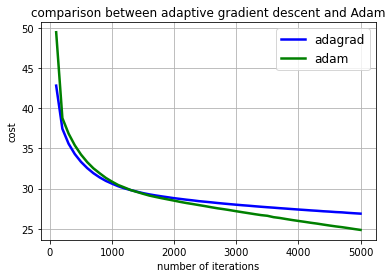

In [27]:
plt.plot(idx_adagrad, err_adagrad, color="blue", linewidth=2.5, linestyle="-", label="adagrad")
plt.plot(idx_adam, err_adam, color="green", linewidth=2.5, linestyle="-", label="adam")
plt.legend(loc='upper right', prop={'size': 12})
plt.title('comparison between adaptive gradient descent and Adam')
plt.xlabel("number of iterations")
plt.ylabel("cost")
plt.grid()
plt.show()      

As we see, Adam achieves the best performance. This demonstrates the effectiveness of combining the idea of momentum and Adagrad / RMSProp.